In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 1. Линейная регрессия. Реализация

In [2]:
data = load_boston()
data['data'].shape

(506, 13)

In [3]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1.1. Реализация линейной регрессии с использованием матричных операций

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где $X$ — матрица объекты-признаки, $y$ — вектор целевых значений, соответствующих $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$

Реализуем выражение для $\theta$ с помощью операций линейной алгебры библиотеки Numpy:

In [4]:
# ЗАДАЧА Реализовать функцию, осуществляющую матричные операции для получения theta
def linreg_linear(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y
  
    return theta

In [5]:
# Подготовить данные

X, y = data['data'], data['target']

X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [6]:
# Вычислить параметр theta
theta = linreg_linear(X, y)

In [7]:
theta.shape

(14,)

In [8]:
# Сделать предсказания для тренировочной выборки
y_pred = X.dot(theta)

In [9]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [10]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


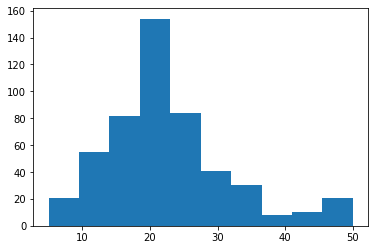

In [11]:
plt.hist(y);

In [12]:
# Разбить выборку на train/valid, вычислить theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [13]:
print_regression_metrics(y_valid, y_pred)
print_regression_metrics(y_train, y_train_pred)

MSE = 33.29, RMSE = 5.77
MSE = 19.37, RMSE = 4.40


In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [15]:
# Реализовать функцию вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

In [16]:
# Реализовать функцию, осуществляющую градиентный шаг
# (функция должна содержать параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

In [17]:
# Реализовать функцию цикла градиентного спуска с доп. параметрами
# начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [18]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [19]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [20]:
theta

array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [21]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  1.    ,  88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,
         8.78  , 100.    ,  12.1265,  24.    , 711.    ,  22.    ,
       396.9   ,  37.97  ])

In [22]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

B
168.3704950393814


In [23]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [24]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [25]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

In [26]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [27]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [28]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68


In [29]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 27.29, RMSE = 5.22


---

In [49]:
X, y = data['data'], data['target']

#X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
from sklearn.linear_model import LinearRegression

In [52]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [53]:
y_pred = model.predict(X_test)
y_pred

array([16.82743855, 25.32322296,  8.67869991, 25.18765109, 18.10630934,
       19.14023344, 23.04203099, 23.7905936 , 29.16285935, 31.38050107,
       25.58719873, 17.69690178, -5.48373179, 16.71003074, 37.96691437,
       18.28855247, 22.20550911, 18.41616683, 30.83724456,  9.22332605,
       13.52714074, 17.0061113 , 22.57615147, 27.93721315, 34.81475855,
       17.92425028, 31.06167782, 23.77676706, 21.11495628, 22.14702065,
       32.28446567,  9.27755934, 35.50399184, 20.609976  , 20.37219618,
       15.35387474, 16.86775027, 15.40250217, 18.67610678, 27.99900278,
       32.8396572 , 22.15162523, 32.233771  , 19.49300225, 16.8458707 ,
       25.99998058, 14.06336034, -0.28373231, 20.71069783, 24.34044694,
       23.14835492, 25.64840404, 24.6272626 , 16.06159235,  0.8282735 ,
       24.14508687, 17.45773278, 15.58341957, 13.67652693, 17.6013498 ,
       22.54542491, 24.48502141, 12.70601605, 30.30994301, 36.36130084,
       20.35742206, 26.8657976 , 40.18110643, 25.02797923, 13.30

In [54]:
print_regression_metrics(y_pred, y_test)

MSE = 26.51, RMSE = 5.15


---

In [55]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
#X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
#m = X.shape[1]

In [57]:
# Оптимизировать параметр линейной регрессии theta на всех данных
#theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)
#theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [58]:
theta

array([ 2.25620630e+01, -9.58574220e-01,  1.02126647e+00, -2.87991577e-03,
        8.79173563e-01, -1.67506676e+00,  2.56923842e+00, -1.98998919e-01,
       -3.15457994e+00,  2.18376676e+00, -1.98769061e+00, -1.99930760e+00,
        6.26898867e-01, -3.68807517e+00])

In [59]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([ 88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,   8.78  ,
       100.    ,  12.1265,  24.    , 711.    ,  22.    , 396.9   ,
        37.97  ])

In [60]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

PTRATIO
168.3704950393814


In [61]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [62]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [63]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

In [64]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [65]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [66]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68


In [67]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 20.70, RMSE = 4.55
